In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2
from src.model.one_class import DeepSVDD
from src.trainer.ids import DeepSVDDIDSTrainer
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label
from src.datamanager.dataset import IDS2017Dataset
from src.bootstrap import store_results

In [5]:
# Setup base folder structure
dataset_path = "../../data/IDS2017/ids2017.csv"
export_path = "deepsvdd_experiments"
if not os.path.exists(export_path):
    os.mkdir(export_path)

# General arguments
batch_size = 1024
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 200

# DeepSVDD-specific arguments
dsvdd_best_epoch = 106

# DAGMM-specific arguments
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6
dagmm_best_epoch = 11

print("arguments set")

arguments set


In [6]:
dataset = IDS2017Dataset(path=dataset_path)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded")

data loaded


## DeepSVDD Training

In [8]:
dsvdd_model = DeepSVDD(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn=act_fn,
)
dsvdd_trainer = DeepSVDDIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    model=dsvdd_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    device=device,
    ckpt_root=os.path.join(export_path, "deepsvdd"),
    run_test_validation=True
)
print("DeepSVDD model and trainer ready")

DeepSVDD model and trainer ready


In [6]:
_ = dsvdd_trainer.train(train_ldr)
dsvdd_trainer.save_ckpt(os.path.join(export_path, "deepsvdd.pt"))

y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=n_epochs, **dsvdd_model.get_params()),
    model_name="DeepSVDD",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

  1%|          | 7/1110 [00:00<00:28, 38.10it/s, epoch=1, loss=0.000]

Started training


100%|██████████| 1110/1110 [00:24<00:00, 45.24it/s, epoch=200, loss=0.000]


{'Precision': 0.5586405396883868,
 'Recall': 0.6418120553831035,
 'F1-Score': 0.5973450921256538,
 'AUPR': 0.7369894596347364,
 'AUROC': 0.8270542027936876,
 'Thresh_star': 5.083045095943817e-12,
 'Quantile_star': 62.18262734570128}

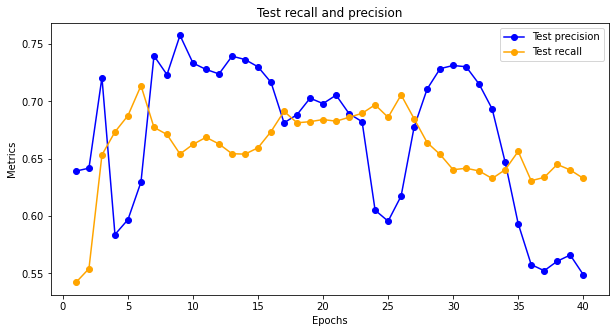

In [11]:
dsvdd_trainer.plot_metrics(os.path.join(export_path, "deepsvdd.png"))

## Inspect misclassifications for every attack type

In [9]:
dsvdd_best_fname = os.path.abspath("./04-29-2022_11-34-47/checkpoints/deepsvdd_epoch=106.pt")
dsvdd_trainer, dsvdd_model = DeepSVDDIDSTrainer.load_from_file(dsvdd_best_fname, dsvdd_trainer, dsvdd_model)
y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=106, **dsvdd_model.get_params()),
    model_name="DeepSVDD",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

{'Precision': 0.6892845497111212,
 'Recall': 0.6861127997661587,
 'F1-Score': 0.6876950176144943,
 'AUPR': 0.7572503960392325,
 'AUROC': 0.8307491939124647,
 'Thresh_star': 2.9990454564199354e-11,
 'Quantile_star': 67.23313239620633}

In [10]:
# Misclassified instances per label
misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
misclf_df["Accuracy"] = 1 - misclf_df["Misclassified ratio"]
misclf_df = misclf_df.sort_values("Misclassified ratio", ascending=False)
misclf_df.to_csv(export_path + "/deepsvdd_misclassifications.csv")
misclf_df

,# Instances test set,Misclassified count,Misclassified ratio
SSH-Patator,5897,5889,0.998643
FTP-Patator,7938,7835,0.987024
Web Attack,2180,2075,0.951835
Bot,1966,1854,0.943032
PortScan,158930,78016,0.490883
DoS,252658,72053,0.285180
BENIGN,1136374,172471,0.151773
Infiltration,36,3,0.083333
DDoS,128027,7312,0.057113
Heartbleed,11,0,0.000000


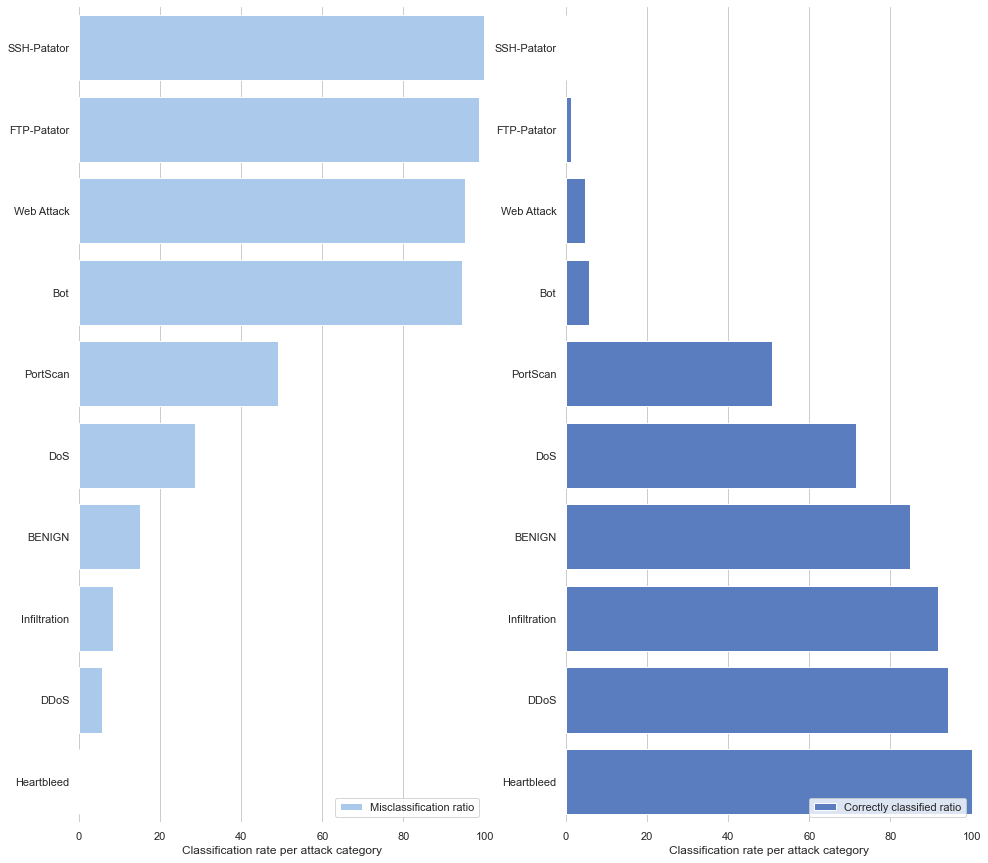

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, axs = plt.subplots(figsize=(16, 15), ncols=2)

# Plot misclassification rates
sns.set_color_codes("pastel")
sns.barplot(
    x=misclf_df["Misclassified ratio"] * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Misclassification ratio",
    color="b",
    ax=axs[0]
)

# Plot correct classification rate
sns.set_color_codes("muted")
sns.barplot(
    x=(1-misclf_df["Misclassified ratio"]) * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Correctly classified ratio",
    color="b",
    ax=axs[1]
)

# Add a legend and informative axis label
for ax in axs:
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=(0, 100), ylabel="", xlabel="Classification rate per attack category")
sns.despine(left=True, bottom=True)

## Gradient analysis

In [12]:
d = dsvdd_trainer.inspect_gradient_wrt_input(partial_anomaly_labels)
y_grad, label_grad = d["y_grad_wrt_X"], d["label_grad_wrt_X"]
labels = d["labels"]

In [13]:
# assumes dataframe ordered from biggest to smallest value
def plt_k_top_vars(dataframe, k, scaler = 1e4):
    sns.set_theme(style="whitegrid")

    # Initialize the matplotlib figure
    figure, axes = plt.subplots(figsize=(16, 15), ncols=2)

    # Plot k biggest
    biggest_df = dataframe[0:k]
    sns.set_color_codes("pastel")
    sns.barplot(
        x=biggest_df["Sum of gradients"] * scaler,
        y=biggest_df["Variable"],
        data=biggest_df,
        label="Sum of gradients",
        color="b",
        ax=axes[0]
    )

    # Plot k smallest
    smallest_df = dataframe[-k:]
    sns.set_color_codes("muted")
    sns.barplot(
        x=smallest_df["Sum of gradients"] * scaler,
        y=smallest_df["Variable"],
        data=smallest_df,
        label="Sum of gradients",
        color="b",
        ax=axes[1]
    )

    # Add a legend and informative axis label
    for ax_i in axes:
        ax_i.legend(ncol=2, loc="lower right", frameon=True)

    xlim_max = biggest_df[0:1]["Sum of gradients"].item() * scaler
    axes[0].set(xlim=(0, xlim_max), xlabel="Top %d variables with highest gradients" % k)
    axes[1].set(xlim=(0, xlim_max), ylabel="", xlabel="Top %d variables with lowest gradients" % k)
    sns.despine(left=True, bottom=True)

In [96]:
np.asarray([label_grad[k].sum(axis=0) for k in label_grad.keys()]).sum(axis=0)

array([-2.5771043e-04,  1.9830175e-05,  1.0585740e-04,  1.0566782e-04,
        7.3816846e-05, -1.2049530e-04, -5.2653209e-05, -2.5501065e-05,
       -3.8928963e-05,  4.9004902e-05,  1.4152544e-05, -7.3862961e-04,
        1.4488795e-04,  6.4056236e-05, -3.1543063e-04,  1.9874458e-06,
       -1.8832633e-04,  1.5838316e-04,  2.1016681e-04, -1.0916126e-05,
        7.8296078e-05, -1.7859011e-04,  5.6048233e-05,  7.2154333e-05,
        4.6995381e-05, -2.9745288e-05, -5.3081014e-05,  3.3117103e-04,
        8.3122795e-05, -4.4418081e-05,  7.4223813e-04,  2.6708623e-04,
        4.5582897e-06,  1.2133976e-04,  4.2223728e-05, -2.2339764e-05,
       -4.1937521e-05,  3.9459596e-06, -1.3095009e-04, -3.3917834e-04,
        7.5308749e-06,  4.0969913e-05, -8.9583318e-07, -2.1324448e-04,
       -6.9268513e-05,  1.0112843e-04,  3.2575022e-05,  1.3644557e-05,
       -4.6310000e-05,  8.0526620e-04, -2.1853858e-04, -8.9811176e-05,
       -2.3971865e-04, -1.5577799e-04, -2.6816563e-04, -3.2285741e-04,
      

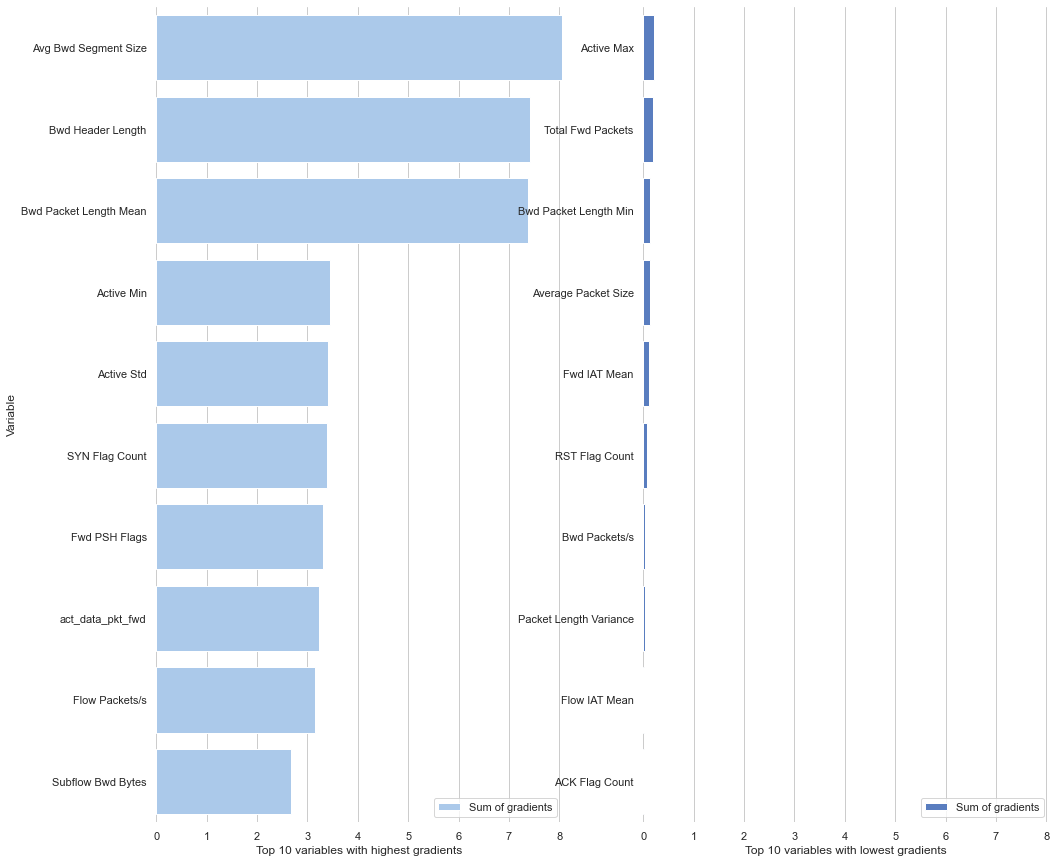

In [97]:
# Overall analysis
gradient_sum = np.asarray([label_grad[k].sum(axis=0) for k in label_grad.keys()]).sum(axis=0)
overall_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(gradient_sum).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
overall_df["Sum of gradients"] = overall_df["Sum of gradients"].astype(np.float32)
overall_df = overall_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(overall_df, k=10)

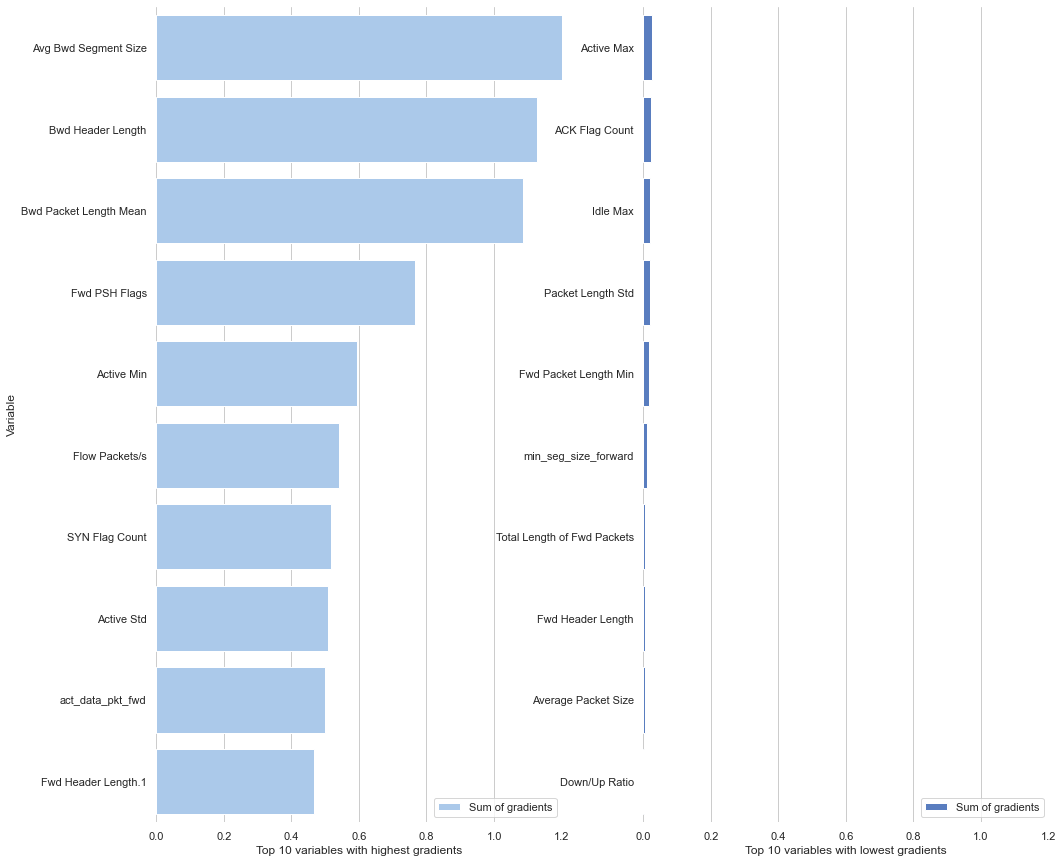

In [14]:
# DDoS analysis
ddos_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(label_grad["DDoS"].sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
ddos_df["Sum of gradients"] = ddos_df["Sum of gradients"].astype(np.float32)
ddos_df = ddos_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(ddos_df, k=10)

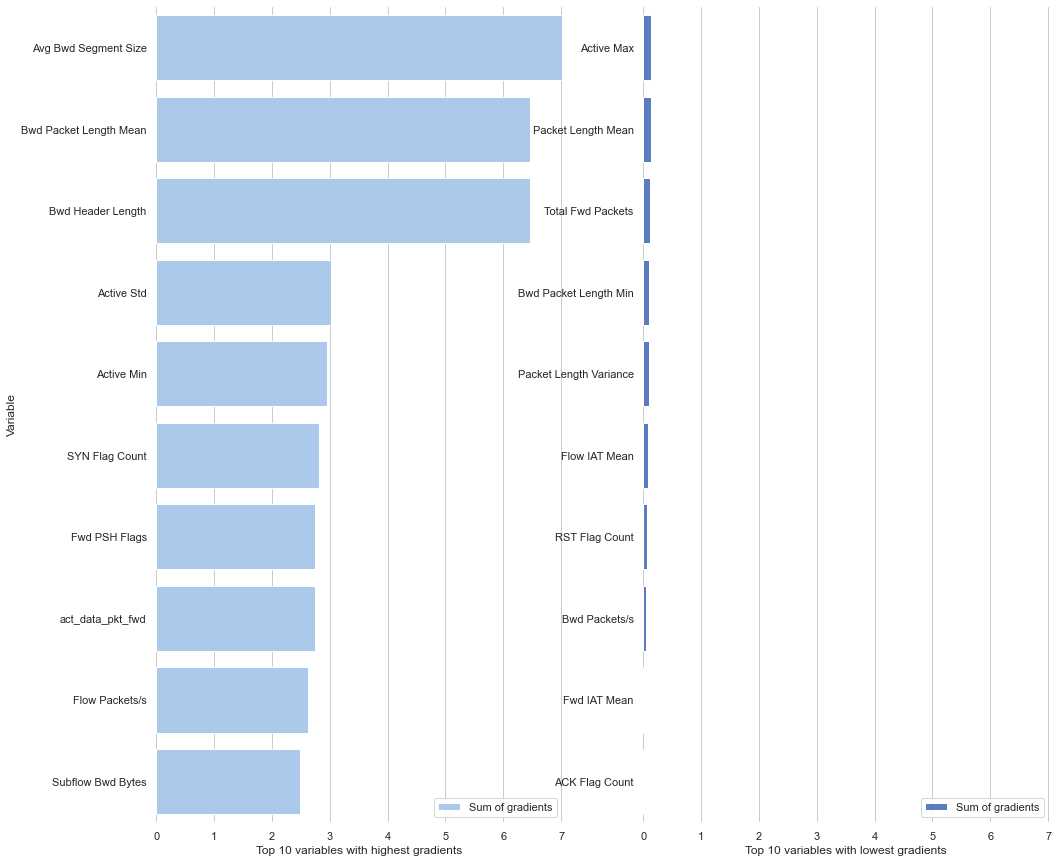

In [15]:
# DoS analysis
dos_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(label_grad["DoS"].sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
dos_df["Sum of gradients"] = dos_df["Sum of gradients"].astype(np.float32)
dos_df = dos_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(dos_df, k=10)

In [16]:
arr = [[], []]
vals = []
for col in label_grad.keys():
    grad_df = pd.DataFrame(np.concatenate(
        (np.array(columns).reshape(65, 1), np.abs(label_grad[col].sum(axis=0)).reshape(65, 1)),
        axis=1),
        columns=["Variable", "Sum of gradients"]
    )
    grad_df["Sum of gradients"] = grad_df["Sum of gradients"].astype(np.float32)
    grad_df = grad_df.sort_values(by=["Sum of gradients"], ascending=False)[0:4]
    arr[0].extend([col] * 4)
    arr[1].extend(grad_df["Variable"].to_list())
    vals.extend(grad_df["Sum of gradients"].to_list())

index = pd.MultiIndex.from_tuples(list(zip(*arr)))
s = pd.Series(vals, index=index)
s

BENIGN        Fwd PSH Flags                  1.267860e-05
              Subflow Bwd Bytes              1.251013e-05
              Bwd Packet Length Mean         1.125921e-05
              Bwd Header Length              1.122494e-05
Bot           Subflow Bwd Bytes              3.413905e-08
              Fwd PSH Flags                  3.059269e-08
              Bwd Packet Length Mean         2.401401e-08
              Bwd Header Length              2.361514e-08
DDoS          Avg Bwd Segment Size           1.201308e-04
              Bwd Header Length              1.126162e-04
              Bwd Packet Length Mean         1.086558e-04
              Fwd PSH Flags                  7.647763e-05
DoS           Avg Bwd Segment Size           7.014094e-04
              Bwd Packet Length Mean         6.467062e-04
              Bwd Header Length              6.465523e-04
              Active Std                     3.025526e-04
FTP-Patator   SYN Flag Count                 4.970092e-08
              

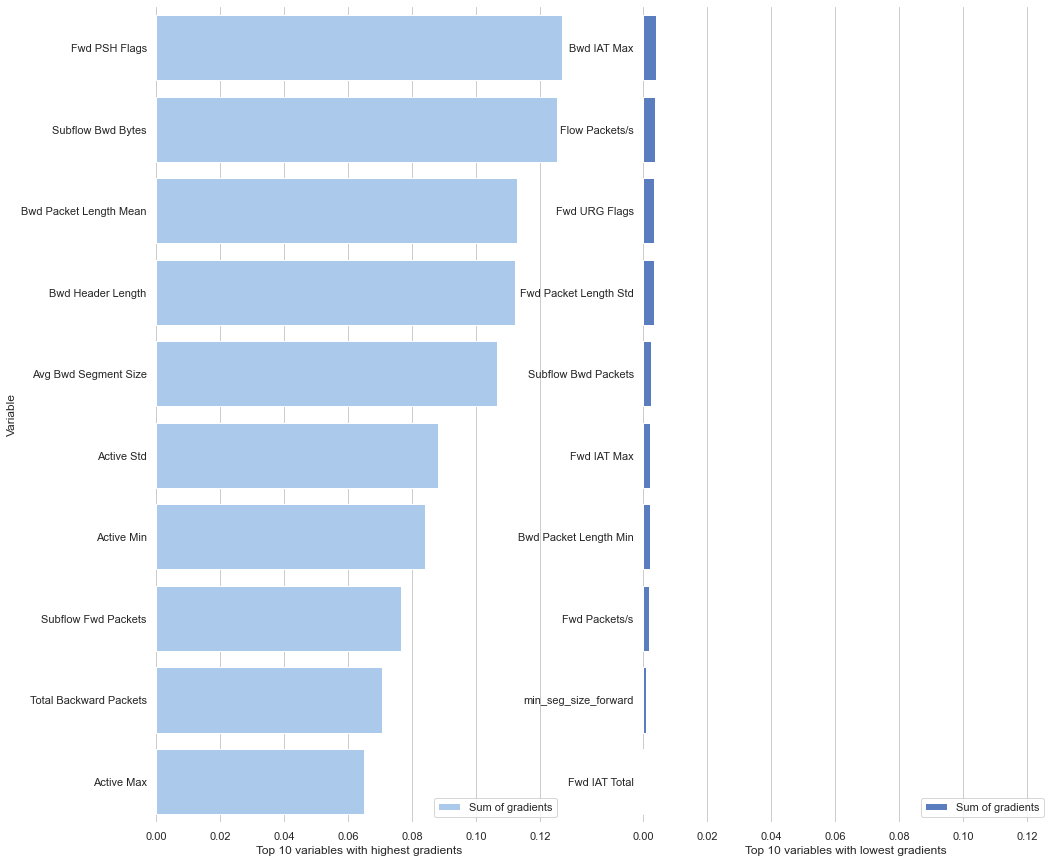

In [17]:
# Normal analysis
benign_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(label_grad["BENIGN"].sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
benign_df["Sum of gradients"] = benign_df["Sum of gradients"].astype(np.float32)
benign_df = benign_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(benign_df, k=10)

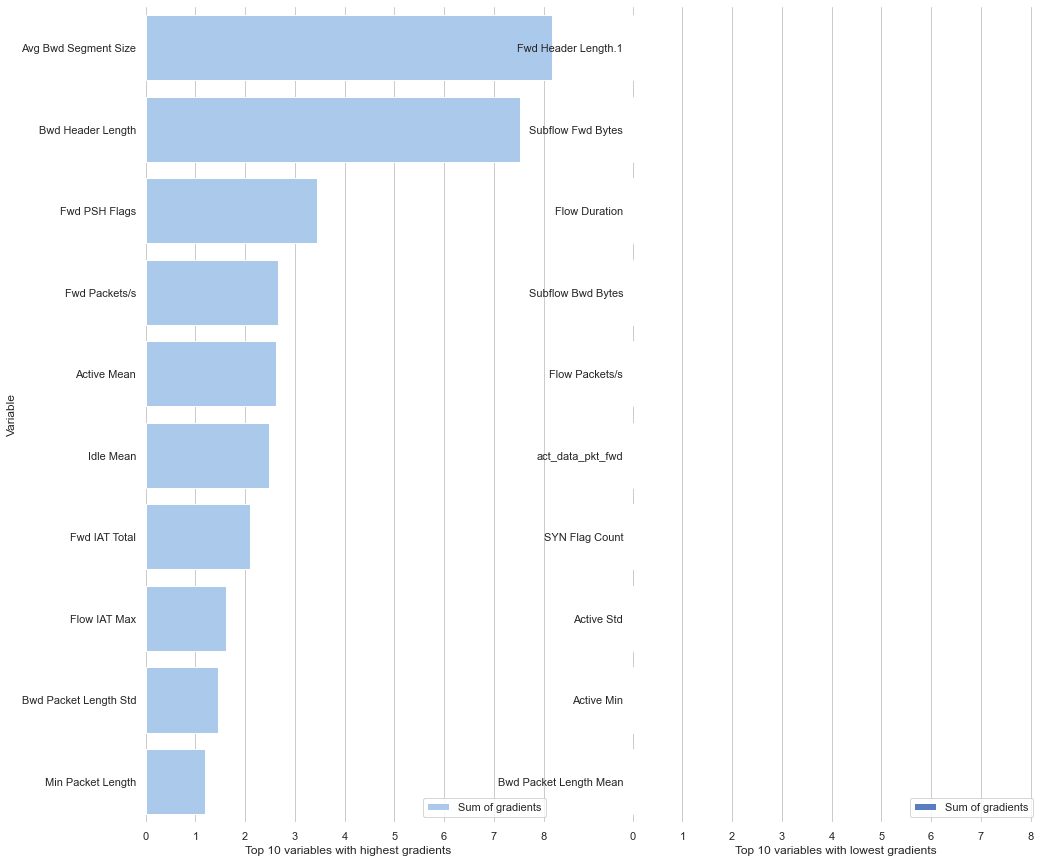

In [25]:
# Attacks analysis
attack_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), (np.asarray([label_grad[k].sum(axis=0) for k in label_grad.keys() if k != "BENIGN"]).sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
attack_df["Sum of gradients"] = attack_df["Sum of gradients"].astype(np.float32)
attack_df = attack_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(attack_df, k=10)

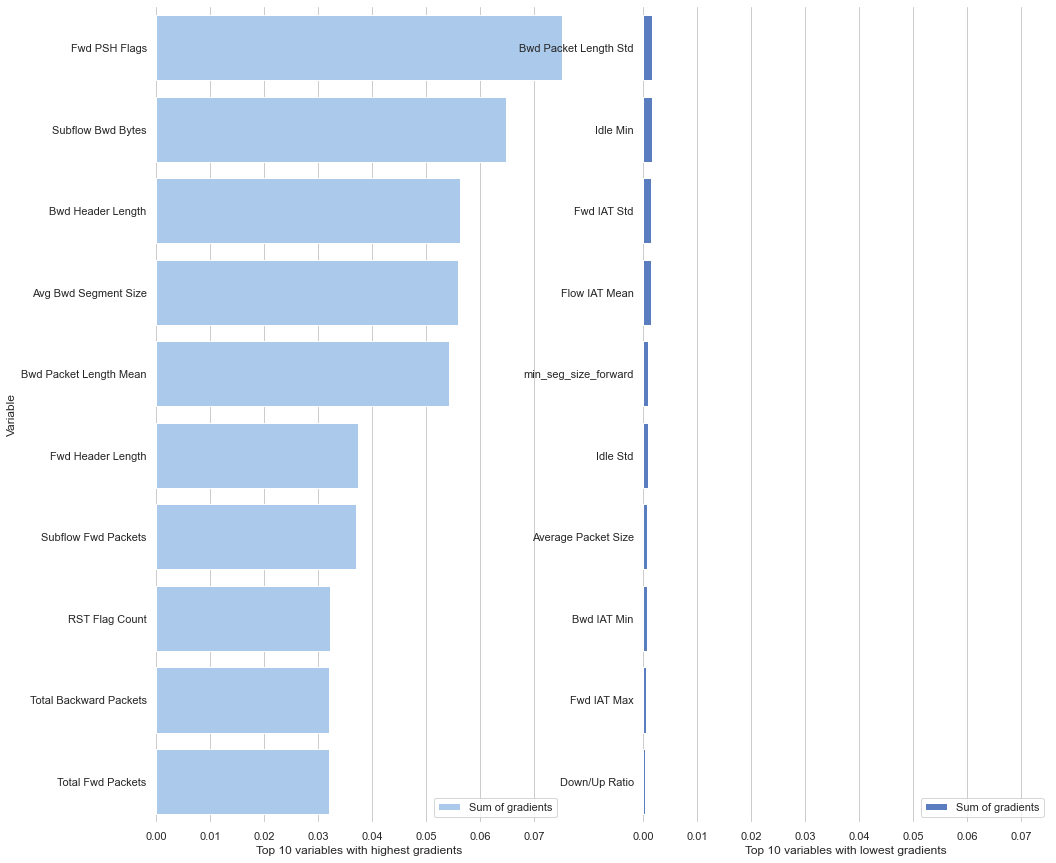

In [81]:
# Portscan analysis
portscan_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(label_grad["PortScan"].sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
portscan_df["Sum of gradients"] = portscan_df["Sum of gradients"].astype(np.float32)
portscan_df = portscan_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(portscan_df, k=10)

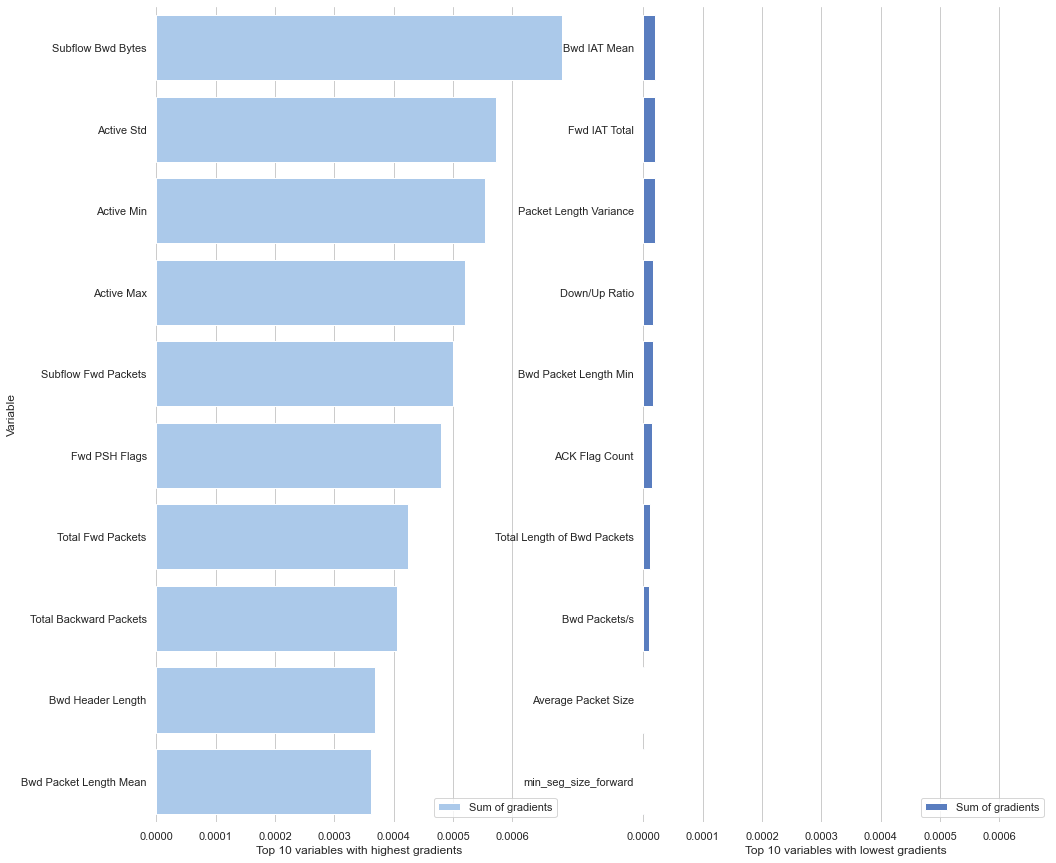

In [82]:
# SSH Patator analysis
ssh_patator_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(label_grad["SSH-Patator"].sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
ssh_patator_df["Sum of gradients"] = ssh_patator_df["Sum of gradients"].astype(np.float32)
ssh_patator_df = ssh_patator_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(ssh_patator_df, k=10)

## Training on feature subset

In [9]:
gradient_top_features = ["Avg Bwd Segment Size", "Bwd Header Length", "Bwd Packet Length Mean", "Active Min", "Active Std"]
catboost_top_features = ["Bwd Packet Length Std", "Bwd Header Length", "Average Packet Size", "Fwd IAT Mean", "Max Packet Length"]
subset_names = ["gradient_based", "catboost_feature_importance"]
results = {n: None for n in subset_names}

for name, features in zip(subset_names, [gradient_top_features, catboost_top_features]):
    print("Training on {}".format(name))
    feature_subset = IDS2017Dataset(path=dataset_path, features=features)

    train_ldr, test_ldr = feature_subset.loaders(batch_size=batch_size, seed=42)

    dsvdd_model = DeepSVDD(
        in_features=feature_subset.in_features,
        n_instances=feature_subset.n_instances,
        device=device,
        n_layers=2,
        compression_factor=2,
        act_fn=act_fn,
    )
    dsvdd_trainer = DeepSVDDIDSTrainer(
        train_ldr=train_ldr,
        test_ldr=test_ldr,
        model=dsvdd_model,
        batch_size=batch_size,
        lr=lr,
        n_epochs=106,
        device=device,
        run_test_validation=False,
        keep_ckpt=False
    )

    print("data loaded")

    _ = dsvdd_trainer.train(train_ldr)
    dsvdd_trainer.save_ckpt(os.path.join(export_path, "deepsvdd_{}.pt".format(name)))

    y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
    res = metrics.estimate_optimal_threshold(test_scores, y_test_true)
    results[name] = res
    print(res)
results

Training on gradient_based
data loaded


  1%|          | 10/1110 [00:00<00:19, 56.07it/s, epoch=1, loss=0.003]

Started training


100%|██████████| 1110/1110 [00:17<00:00, 62.23it/s, epoch=106, loss=0.000]


{'Precision': 0.4486359608153098, 'Recall': 0.8733293522916992, 'F1-Score': 0.5927643474286577, 'AUPR': 0.4738281030954407, 'AUROC': 0.7022495179306927, 'Thresh_star': 7.993605777301127e-15, 'Quantile_star': 62.081617244691174}
Training on catboost_feature_importance
data loaded


  1%|          | 9/1110 [00:00<00:20, 55.05it/s, epoch=1, loss=0.006]

Started training


100%|██████████| 1110/1110 [00:18<00:00, 60.39it/s, epoch=106, loss=0.000]


{'Precision': 0.32918382755308834, 'Recall': 1.0, 'F1-Score': 0.4953172326194897, 'AUPR': 0.3515045490178112, 'AUROC': 0.5166369881806102, 'Thresh_star': 0.0, 'Quantile_star': 62.081617244691174}


{'gradient_based': {'Precision': 0.4486359608153098,
  'Recall': 0.8733293522916992,
  'F1-Score': 0.5927643474286577,
  'AUPR': 0.4738281030954407,
  'AUROC': 0.7022495179306927,
  'Thresh_star': 7.993605777301127e-15,
  'Quantile_star': 62.081617244691174},
 'catboost_feature_importance': {'Precision': 0.32918382755308834,
  'Recall': 1.0,
  'F1-Score': 0.4953172326194897,
  'AUPR': 0.3515045490178112,
  'AUROC': 0.5166369881806102,
  'Thresh_star': 0.0,
  'Quantile_star': 62.081617244691174}}